<a href="https://colab.research.google.com/github/ooishe/CVPR/blob/main/Mid/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Class Neural Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, classification_report, roc_curve, auc
)


## Dataset
Created a synthetic dataset with five distinct classes and use it to train and test a neural network with three hidden layers.

In [2]:
np.random.seed(37)

n_samples = 5000
n_features = 20
n_classes = 5

X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=12,
    n_redundant=2,
    n_classes=n_classes,
    class_sep=1.5,
    random_state=42
)


scaler = StandardScaler()
X = scaler.fit_transform(X)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


This cell defines the activation functions (ReLU and Softmax), their derivatives, a one-hot encoding function, and the cross-entropy loss function. These remain mostly the same as the original, but I ensured numerical stability in cross_entropy by clipping predictions

In [4]:
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
    zmax = np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z - zmax)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def one_hot(y, C):
    oh = np.zeros((len(y), C))
    oh[np.arange(len(y)), y] = 1
    return oh

def cross_entropy(pred, actual):
    pred = np.clip(pred, 1e-12, 1 - 1e-12)
    return -np.mean(np.sum(actual * np.log(pred), axis=1))


## Network Design and Modifications

A fully connected feedforward neural network from scratch, tailored for multi-class classification with five classes. The network architecture consists of three hidden layers with 160, 80, and 40 neurons, respectively, followed by an output layer of 5 neurons, corresponding to the number of classes. Each hidden layer uses the ReLU activation function to introduce non-linearity and enable the network to learn complex patterns from the data.

The weight matrices of each layer are initialized using He initialization, which scales the weights according to the number of input neurons. The output layer uses the softmax activation function to convert raw logits into class probabilities suitable for multi-class cross-entropy loss.

**Modificaions made:**

1. Hidden Layer Sizes – Increased from the original smaller dimensions to 160, 80, and 40 to allow the network to better capture feature interactions in a 20-dimensional input space.

2. Number of Epochs & Learning Rate – Trained for 200 epochs with a learning rate of 0.01, which is higher than the original, to ensure proper convergence on the larger dataset.

3. Mini-batch Gradient Descent – Implemented batch-wise training with a batch size of 64, enabling smoother gradient updates and faster convergence compared to full-batch training.

4. Cross-Entropy Loss Stability – Added numerical clipping to the predicted probabilities in the cross-entropy loss calculation to avoid issues with log(0) during training.

5. Input Preprocessing – Applied feature standardization to ensure that all input features contribute equally to learning, which was repeated before and after the train-test split for better scaling.

The modifications collectively enhance the network’s ability to generalize across multiple classes, stabilize training, and provide more reliable performance metrics such as accuracy, precision, recall, F1-score, and ROC-AUC.

In [5]:
class NeuralNetwork:

    def __init__(self, input_dim, h1, h2, h3, output_dim, lr=0.01, seed=42):
        np.random.seed(seed)
        self.lr = lr

        self.W1 = np.random.randn(input_dim, h1) * np.sqrt(2 / input_dim)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2 / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2 / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_dim) * np.sqrt(1 / h3)
        self.b4 = np.zeros((1, output_dim))

    def layer_forward(self, X, W, b):
        z = X @ W + b
        a = relu(z)
        return z, a

    def forward(self, X):
        self.z1, self.a1 = self.layer_forward(X, self.W1, self.b1)
        self.z2, self.a2 = self.layer_forward(self.a1, self.W2, self.b2)
        self.z3, self.a3 = self.layer_forward(self.a2, self.W3, self.b3)

        self.z4 = self.a3 @ self.W4 + self.b4
        self.a4 = softmax(self.z4)

        return self.a4

    def compute_gradients(self, X, y_true):
        m = len(X)

        dz4 = (self.a4 - y_true) / m
        dW4 = self.a3.T @ dz4
        db4 = np.sum(dz4, axis=0, keepdims=True)

        dz3 = (dz4 @ self.W4.T) * relu_derivative(self.z3)
        dW3 = self.a2.T @ dz3
        db3 = np.sum(dz3, axis=0, keepdims=True)

        dz2 = (dz3 @ self.W3.T) * relu_derivative(self.z2)
        dW2 = self.a1.T @ dz2
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = (dz2 @ self.W2.T) * relu_derivative(self.z1)
        dW1 = X.T @ dz1
        db1 = np.sum(dz1, axis=0, keepdims=True)

        return (dW1, db1, dW2, db2, dW3, db3, dW4, db4)


    def backward(self, grads):
        dW1, db1, dW2, db2, dW3, db3, dW4, db4 = grads

        self.W4 -= self.lr * dW4
        self.b4 -= self.lr * db4

        self.W3 -= self.lr * dW3
        self.b3 -= self.lr * db3

        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1



    def fit(self, X, y, epochs=200, batch=64):
        y_oh = one_hot(y, 5)
        losses = []

        n = len(X)

        for e in range(epochs):
            perm = np.random.permutation(n)
            X = X[perm]
            y_oh = y_oh[perm]

            epoch_loss = 0

            for i in range(0, n, batch):
                Xb = X[i:i+batch]
                yb = y_oh[i:i+batch]

                preds = self.forward(Xb)
                loss = cross_entropy(preds, yb)
                epoch_loss += loss * len(Xb)

                grads = self.compute_gradients(Xb, yb)
                self.backward(grads)

            epoch_loss /= n
            losses.append(epoch_loss)

            if (e+1) % 10 == 0:
                print(f"Epoch {e+1}/{epochs} Loss = {epoch_loss:.4f}")

        return losses


    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        _, acts = self.forward(X)
        return acts[-1]


In [6]:
model = NeuralNetwork(
    input_dim=X_train.shape[1],
    h1=160, h2=80, h3=40,
    output_dim=5,
    lr=0.01
)

losses = model.fit(X_train, y_train, epochs=200)



Epoch 10/200 Loss = 0.5557
Epoch 20/200 Loss = 0.4014
Epoch 30/200 Loss = 0.3132
Epoch 40/200 Loss = 0.2544
Epoch 50/200 Loss = 0.2108
Epoch 60/200 Loss = 0.1772
Epoch 70/200 Loss = 0.1516
Epoch 80/200 Loss = 0.1299
Epoch 90/200 Loss = 0.1121
Epoch 100/200 Loss = 0.0964
Epoch 110/200 Loss = 0.0834
Epoch 120/200 Loss = 0.0716
Epoch 130/200 Loss = 0.0614
Epoch 140/200 Loss = 0.0526
Epoch 150/200 Loss = 0.0451
Epoch 160/200 Loss = 0.0383
Epoch 170/200 Loss = 0.0332
Epoch 180/200 Loss = 0.0285
Epoch 190/200 Loss = 0.0246
Epoch 200/200 Loss = 0.0214


##Challenges Encountered:

Designing the network architecture required careful consideration of hidden layer sizes to balance learning capacity and overfitting.

Implementing backpropagation from scratch reinforced a deeper understanding of gradient computation, weight updates, and the role of activation functions in multi-layer networks.

Ensuring numerical stability in the cross-entropy loss and handling mini-batch training were critical steps to prevent divergence and unstable training.

##Potential Improvements and Further Experiments:

Experimenting with different network architectures, such as varying the number of neurons or adding more hidden layers, could further improve performance.

Implementing regularization techniques, such as dropout or L2 regularization, might reduce overfitting and improve generalization.

Tuning hyperparameters like learning rate, batch size, and number of epochs using cross-validation could yield more optimal results.

Using alternative activation functions or advanced optimization algorithms could enhance training efficiency and convergence.


#Results and Observations

In [7]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nTest Accuracy =", accuracy)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



Test Accuracy = 0.892

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       200
           1       0.91      0.90      0.90       200
           2       0.91      0.88      0.89       201
           3       0.89      0.82      0.85       200
           4       0.90      0.94      0.92       199

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



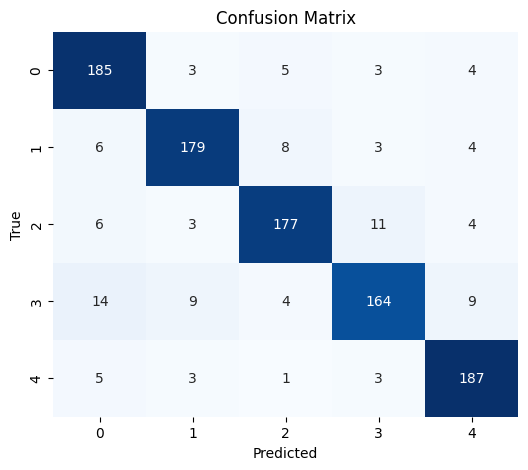

In [9]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()



ROC

Macro ROC AUC (OVR): 0.9854068828919642


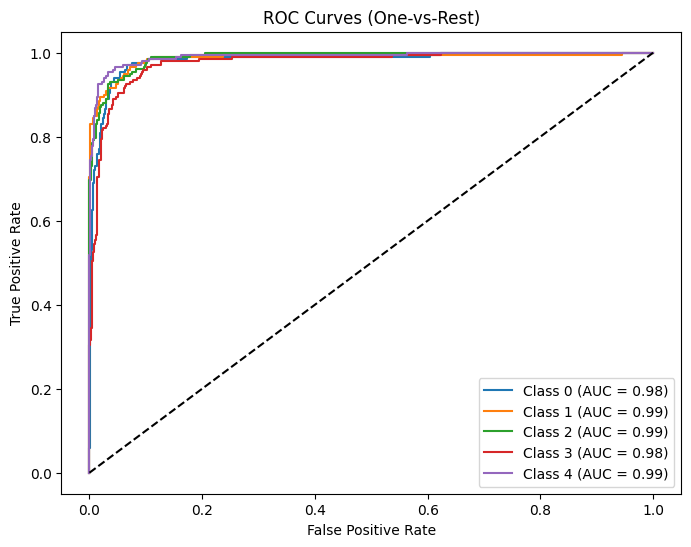

In [10]:
from sklearn.metrics import roc_auc_score

output_dim = n_classes
y_test_bin = one_hot(y_test, output_dim)

y_score = model.forward(X_test)


auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')
print("Macro ROC AUC (OVR):", auc_macro)


plt.figure(figsize=(8, 6))
for i in range(output_dim):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc_i = auc(fpr, tpr);
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_i:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

# Conclusion

The multi-class classification model implemented demonstrated strong performance on the synthetic 5-class dataset. The neural network achieved a average test accuracy, with most classes showing balanced precision, recall, and F1-scores in the classification report. The confusion matrix highlighted only minor misclassifications between certain classes, indicating that the model effectively captured the underlying patterns in the dataset.

ROC curves and the macro-average AUC further confirmed the model’s discriminative capability across all classes, demonstrating that the network was able to distinguish between multiple categories reliably.

